My foray into graph neural networks

## What is a graph?

## what does a graphical data look like?

In [1]:
import torch
import torch_geometric as tg

In [5]:

edge_index = torch.tensor([[0, 1, 1, 2],
                           [1, 0, 2, 1]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

data = tg.data.Data(x=x, edge_index=edge_index)
data

Data(x=[3, 1], edge_index=[2, 4])

The nodes define what is connected. This is a graph with 3 nodes `-1, 0 and 1`

The edges define the connections too: `0 -> 1`, `1 -> 0`, `1 -> 2`, and `2 -> 1`

### Graphs shold have a few things

- x: the data, node feature matrix with shape `[num_nodes, num_node_features]`

- edge_index: Graph connectivity in coordinate format with shape `[2, num_edges]` and type torch.long

- edge_attr: Edge feature matrix with shape `[num_edges, num_edge_features]` (note that edges can have features too)

- y: Target to train against (may have arbitrary shape), e.g., node-level targets of shape `[num_nodes, *]` or graph-level targets of shape `[1, *]`

- pos: Node position matrix with shape `[num_nodes, num_dimensions]`

## given a graph data type in torch, you can do a few things:

validate the graph

In [7]:
data.validate(raise_on_error=True)

True

Count how many nodes and edges

In [8]:
data.num_nodes

3

In [11]:
data.edge_index.shape

torch.Size([2, 4])

In [12]:
data.num_edge_features # no features for the edges

0

In [14]:
data.num_node_features # just one feature for each node

1

is the graph directed?

In [15]:
data.is_directed()

False

## Let's look at a real-life dataset

In [3]:
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES')
dataset

ENZYMES(600)

There are 600 graphs in this dataset. Each graph is a protein structure; 600 protein structures. We can look at one of them...

In [7]:
a_protein_graph = dataset[1]
a_protein_graph

Data(edge_index=[2, 102], x=[23, 3], y=[1])

This protein graph has 23 nodes and 3 node-level features. There are no edge attributes. `y` refers to the class of protein, and there are 102 connections.  

In [8]:
b_protein_graph = dataset[0]
b_protein_graph

Data(edge_index=[2, 168], x=[37, 3], y=[1])

Another one. 

We can split all the 600 graphs into 2, so that we train on some, and test on another.

In [9]:
train_graphs = dataset[:500]
test_graphs = dataset[500:]

train_graphs, test_graphs

(ENZYMES(500), ENZYMES(100))

## Training a graph neural net

Let's use another dataset, [Cora](https://paperswithcode.com/dataset/cora#:~:text=The%20Cora%20dataset%20consists%20of,corresponding%20word%20from%20the%20dictionary.), a less complex dataset:

In [159]:
from torch_geometric.datasets import Planetoid
import torchsummary

dataset = Planetoid(root='/tmp/Cora', name='Cora')
dataset

Cora()

In [17]:
len(dataset)

1

In [18]:
data = dataset[0]
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [22]:
dataset.num_classes, data.num_node_features

(7, 1433)

So, this dataset has 2708 nodes, and `1433` node-level features. 
It has `10556` connectivities. 

In [44]:
import torch.nn.functional as F
from torch_geometric.loader import DataLoader

In [236]:
class SimpleGNN(torch.nn.Module):
    def __init__(self, nnode_features, num_classes, num_layers=3):
        super().__init__()
        self.conv1 = tg.nn.GCNConv(in_channels=nnode_features, out_channels=8)
        #self.mlp = tg.nn.models.MLP(in_channels=16, out_channels=16, hidden_channels=4, num_layers=3, dropout=0.4, act='relu')
        
        self.layers = torch.nn.ModuleList()
        self.layers.append(torch.nn.Linear(in_features=8, out_features=4))
        self.layers.append(torch.nn.ReLU())
        for _ in range(num_layers - 2):
            self.layers.append(torch.nn.Linear(in_features=4, out_features=4))
            self.layers.append(torch.nn.ReLU())
        self.layers.append(torch.nn.Linear(in_features=4, out_features=4))

        self.conv2 = tg.nn.GCNConv(in_channels=4, out_channels=num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        # x = self.mlp(x)
        # x = F.relu(x)
        for layer in self.layers:
            x = layer(x)
        x = self.conv2(x, edge_index)
        
        return(F.log_softmax(x, dim=1))

In [237]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleGNN(nnode_features=dataset.num_node_features, num_classes=dataset.num_classes, num_layers=1).to(device)
print(tg.nn.summary(model, dataset[0])) 

+----------------------+--------------------------+----------------+----------+
| Layer                | Input Shape              | Output Shape   | #Param   |
|----------------------+--------------------------+----------------+----------|
| SimpleGNN            | [2708, 2708]             | [2708, 7]      | 11,563   |
| ├─(conv1)GCNConv     | [2708, 1433], [2, 10556] | [2708, 8]      | 11,472   |
| ├─(layers)ModuleList | --                       | --             | 56       |
| │    └─(0)Linear     | [2708, 8]                | [2708, 4]      | 36       |
| │    └─(1)ReLU       | [2708, 4]                | [2708, 4]      | --       |
| │    └─(2)Linear     | [2708, 4]                | [2708, 4]      | 20       |
| ├─(conv2)GCNConv     | [2708, 4], [2, 10556]    | [2708, 7]      | 35       |
+----------------------+--------------------------+----------------+----------+


In [242]:
lls = ([], [], [], [])
train_loss_tally, train_acc_tally, test_loss_tally, test_acc_tally = lls

data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=5e-5)

model.train()
for epoch in range(10000):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    train_loss_tally.append(loss.item())

    pred = out.argmax(dim=1)
    correct = (pred[data.train_mask] == data.y[data.train_mask]).sum()
    acc = int(correct) / int(data.train_mask.sum())
    train_acc_tally.append(acc)
    
    optimizer.step()

    model.eval()
    loss = F.nll_loss(out[data.test_mask], data.y[data.test_mask])
    test_loss_tally.append(loss.item())

    pred = out.argmax(dim=1)
    correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
    acc = int(correct) / int(data.test_mask.sum())
    test_acc_tally.append(acc) 

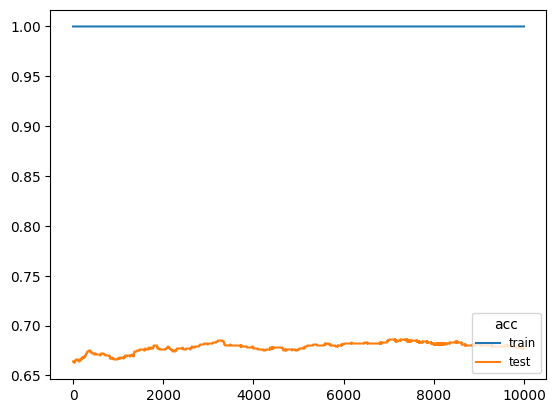

In [243]:
import matplotlib.pyplot as plt

plt.plot(train_acc_tally, label = 'train')
plt.plot(test_acc_tally, label = 'test')
plt.legend(title="acc",loc=4, fontsize='small', fancybox=True)

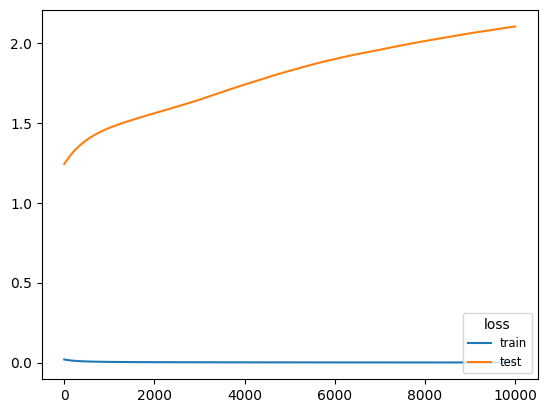

In [244]:
plt.plot(train_loss_tally, label = 'train')
plt.plot(test_loss_tally, label = 'test')
plt.legend(title="loss",loc=4, fontsize='small', fancybox=True)

In [241]:
model.eval()
pred = model(data).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.6640
